In [1]:
import pandas as pd
from evaluations.evaluation_data.evaluation_data import EvaluationData
from tampering.tampering import Tampering
from timf.timf import TIMF
from data_service.data_service import DataService
import numpy as np


evaluation_data = EvaluationData()
tampering = Tampering()
        
data_service = DataService()
timf = TIMF(data_service)

data = evaluation_data.get_data()


tampering_percentages = list(range(10, 100, 20))

tampering_types = ["N", "K", "S"]  # Naive, Knowledgeable, Sophisticated
# tampering_types = ["N"]
        
results = []

def _haversine_km(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    return 6371.0 * c

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

def compute_metrics_from_labels(y_true_labels, y_pred_labels):
    """
    Inputs are arrays/Series with values 'T' or 'C'
    """
    y_true = (pd.Series(y_true_labels) == 'T').astype(int)
    y_pred = (pd.Series(y_pred_labels) == 'T').astype(int)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)

    try:
        auc = roc_auc_score(y_true, y_pred)
    except ValueError:
        auc = None

    return accuracy, precision, recall, auc


Loaded existing evaluation data from CSV.


In [2]:
results_metrics = []

for tampering_type in tampering_types:
    for tampering_percentage in tampering_percentages:

        print(f"Experiment: Tampering Type={tampering_type}, Percentage={tampering_percentage}%")

        for assessing_mic in data['gen_microcell'].unique():

            df_microcell = data[data['gen_microcell'] == assessing_mic]

            # -------- Remote tampering (BMA) --------
            bma_tampered_df = tampering.bma_tampering(
                data[data['gen_microcell'] != assessing_mic].reset_index(drop=True),
                tampering_percentage,
                tampering_type
            )

            remote_data = bma_tampered_df.copy()

            # -------- Replication logic --------
            microcell_coords = data.groupby('gen_microcell')[['latitude', 'longitude']].first().reset_index()
            current_coords = microcell_coords[microcell_coords['gen_microcell'] == assessing_mic]

            if not current_coords.empty:
                lat1 = current_coords['latitude'].values[0]
                lon1 = current_coords['longitude'].values[0]

                df_microcell_part = df_microcell.copy()
                df_microcell_part.loc[:, 'currect_microcell'] = assessing_mic

                replicated_parts = [df_microcell_part]

                for provider_id in df_microcell['providerid'].unique():

                    provider_remote = remote_data[remote_data['providerid'] == provider_id]
                    candidate_microcells = []

                    for _, row in microcell_coords.iterrows():
                        if row['gen_microcell'] == assessing_mic:
                            continue
                        if (provider_remote['gen_microcell'] == row['gen_microcell']).any():
                            dist = _haversine_km(lat1, lon1, row['latitude'], row['longitude'])
                            candidate_microcells.append((row['gen_microcell'], dist))

                    candidate_microcells.sort(key=lambda x: x[1])
                    nearby_microcells = [m for m, _ in candidate_microcells[:10]]

                    if nearby_microcells:
                        df_remote = remote_data[
                            (remote_data['providerid'] == provider_id) &
                            (remote_data['gen_microcell'].isin(nearby_microcells))
                        ].drop_duplicates(subset='serviceid')

                        if not df_remote.empty:
                            df_remote['origin'] = 'R'
                            df_remote['currect_microcell'] = assessing_mic
                            replicated_parts.append(df_remote)

                df_microcell_replicated = pd.concat(replicated_parts, ignore_index=True)
            else:
                df_microcell_replicated = df_microcell.copy()

            # -------- Local tampering (SPA) --------
            spa_tampered_df = tampering.spa_tampering(
                df_microcell_replicated,
                type=tampering_type
            )

            # -------- Set TIMF data --------
            data_service.set_local_data(spa_tampered_df.copy())
            # data_service.set_remote_data(bma_tampered_df.copy())
            data_service.set_remote_data(data[data['gen_microcell'] != assessing_mic].copy())

            # =====================================================
            # TDA: COLLECT labels across providers
            # =====================================================
            # =====================================================
            # Unified: COLLECT TDA + BASELINES across providers
            # =====================================================
            tda_true, tda_pred = [], []
            tda_time_entries = []

            baseline_true = {'IsolationForest': [], 'LOF': [], 'OCSVM': []}
            baseline_pred = {'IsolationForest': [], 'LOF': [], 'OCSVM': []}
            baseline_time_entries = {'IsolationForest': [], 'LOF': [], 'OCSVM': []}

            for provider in df_microcell['providerid'].unique():

                # ---------- TDA ----------
                _, df_tda, time_df = timf.trust_assessment(provider, assessing_mic)

                if df_tda is not None and not df_tda.empty:
                    tda_true.extend(df_tda['true_label'])
                    tda_pred.extend(df_tda['label'])

                if isinstance(time_df, dict):
                    tda_time_entries.append({
                        'records': time_df.get('records', np.nan),
                        'time_sec': time_df.get('time', np.nan)
                    })

                # ---------- Baseline: IsolationForest ----------
                df_if, t_if = timf.trust_assessment_baseline_ifum(provider, assessing_mic)

                if df_if is not None and not df_if.empty:
                    baseline_true['IsolationForest'].extend(df_if['true_label'])
                    baseline_pred['IsolationForest'].extend(df_if['label'])

                if isinstance(t_if, dict):
                    baseline_time_entries['IsolationForest'].append({
                        'records': t_if.get('records', np.nan),
                        'time_sec': t_if.get('time', np.nan)
                    })

                # ---------- Baseline: LOF ----------
                df_lof, t_lof = timf.trust_assessment_baseline_lof(provider, assessing_mic)

                if df_lof is not None and not df_lof.empty:
                    baseline_true['LOF'].extend(df_lof['true_label'])
                    baseline_pred['LOF'].extend(df_lof['label'])

                if isinstance(t_lof, dict):
                    baseline_time_entries['LOF'].append({
                        'records': t_lof.get('records', np.nan),
                        'time_sec': t_lof.get('time', np.nan)
                    })

                # ---------- Baseline: OCSVM ----------
                df_oc, t_oc = timf.trust_assessment_baseline_ocsvm(provider, assessing_mic)

                if df_oc is not None and not df_oc.empty:
                    baseline_true['OCSVM'].extend(df_oc['true_label'])
                    baseline_pred['OCSVM'].extend(df_oc['label'])

                if isinstance(t_oc, dict):
                    baseline_time_entries['OCSVM'].append({
                        'records': t_oc.get('records', np.nan),
                        'time_sec': t_oc.get('time', np.nan)
                    })

            # =====================================================
            # Save rows (TDA + baselines)
            # =====================================================
            rows_to_add = []

            # ---- TDA row
            if len(tda_true) > 0:
                acc, prec, rec, auc = compute_metrics_from_labels(tda_true, tda_pred)
                rows_to_add.append({
                    'tampering_type': tampering_type,
                    'tampering_percentage': tampering_percentage,
                    'microcell': assessing_mic,
                    'provider_id': 'ALL',
                    'method': 'TDA',
                    'accuracy': acc,
                    'precision': prec,
                    'recall': rec,
                    'AUC': auc,
                    'time_records': tda_time_entries
                })

            # ---- Baseline rows
            for method_name in ['IsolationForest', 'LOF', 'OCSVM']:
                if len(baseline_true[method_name]) == 0:
                    continue

                acc, prec, rec, auc = compute_metrics_from_labels(
                    baseline_true[method_name],
                    baseline_pred[method_name]
                )

                rows_to_add.append({
                    'tampering_type': tampering_type,
                    'tampering_percentage': tampering_percentage,
                    'microcell': assessing_mic,
                    'provider_id': 'ALL',
                    'method': method_name,
                    'accuracy': acc,
                    'precision': prec,
                    'recall': rec,
                    'AUC': auc,
                    'time_records': baseline_time_entries[method_name]
                })

            results_metrics.extend(rows_to_add)


Experiment: Tampering Type=N, Percentage=10%
Experiment: Tampering Type=N, Percentage=30%
Experiment: Tampering Type=N, Percentage=50%
Experiment: Tampering Type=N, Percentage=70%
Experiment: Tampering Type=N, Percentage=90%
Experiment: Tampering Type=K, Percentage=10%
Experiment: Tampering Type=K, Percentage=30%
Experiment: Tampering Type=K, Percentage=50%
Experiment: Tampering Type=K, Percentage=70%
Experiment: Tampering Type=K, Percentage=90%
Experiment: Tampering Type=S, Percentage=10%
Experiment: Tampering Type=S, Percentage=30%
Experiment: Tampering Type=S, Percentage=50%
Experiment: Tampering Type=S, Percentage=70%
Experiment: Tampering Type=S, Percentage=90%


In [3]:
results_metrics

[{'tampering_type': 'N',
  'tampering_percentage': 10,
  'microcell': 'M102',
  'provider_id': 'ALL',
  'method': 'TDA',
  'accuracy': 0.9326488706365503,
  'precision': 1.0,
  'recall': 0.8739431206764028,
  'AUC': np.float64(0.9369715603382014),
  'time_records': [{'records': 619, 'time_sec': 0.3863961696624756},
   {'records': 187, 'time_sec': 0.07973575592041016},
   {'records': 433, 'time_sec': 0.25121212005615234},
   {'records': 62, 'time_sec': 0.024296045303344727},
   {'records': 89, 'time_sec': 0.035974740982055664},
   {'records': 48, 'time_sec': 0.021461963653564453},
   {'records': 225, 'time_sec': 0.09431695938110352},
   {'records': 53, 'time_sec': 0.02655506134033203},
   {'records': 77, 'time_sec': 0.025224924087524414},
   {'records': 63, 'time_sec': 0.02102184295654297},
   {'records': 99, 'time_sec': 0.03893589973449707},
   {'records': 72, 'time_sec': 0.02530527114868164},
   {'records': 57, 'time_sec': 0.0210111141204834},
   {'records': 351, 'time_sec': 0.1075191

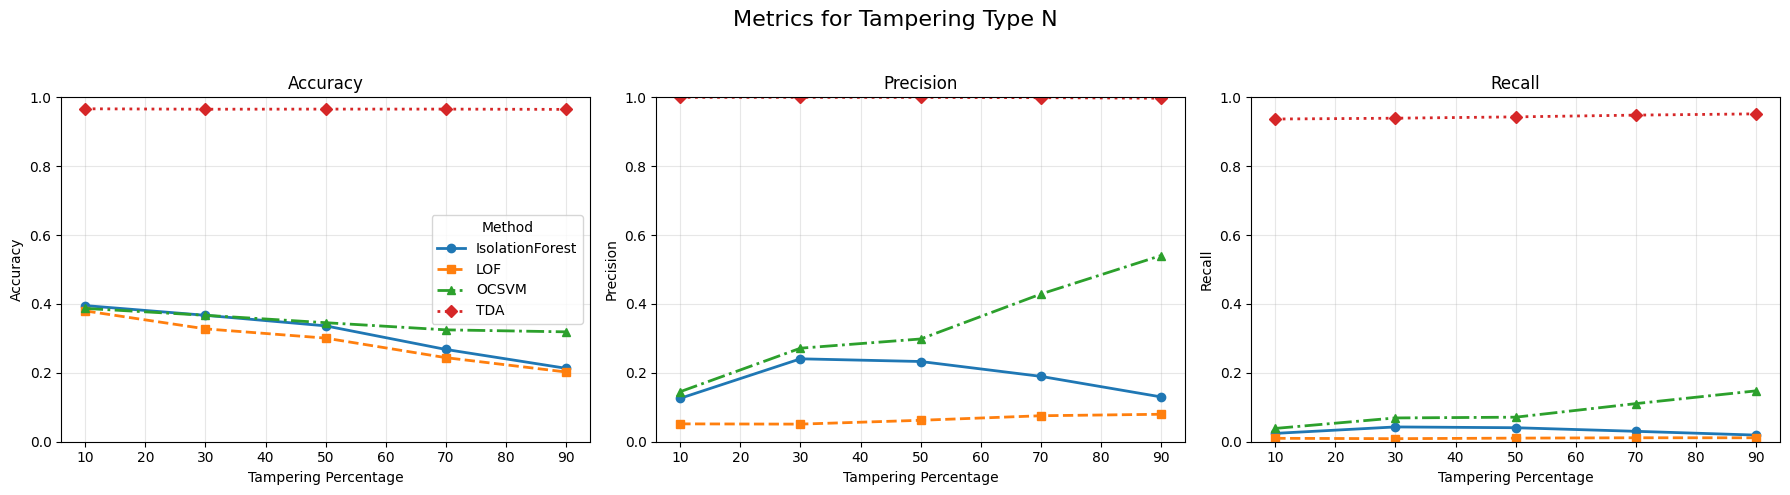

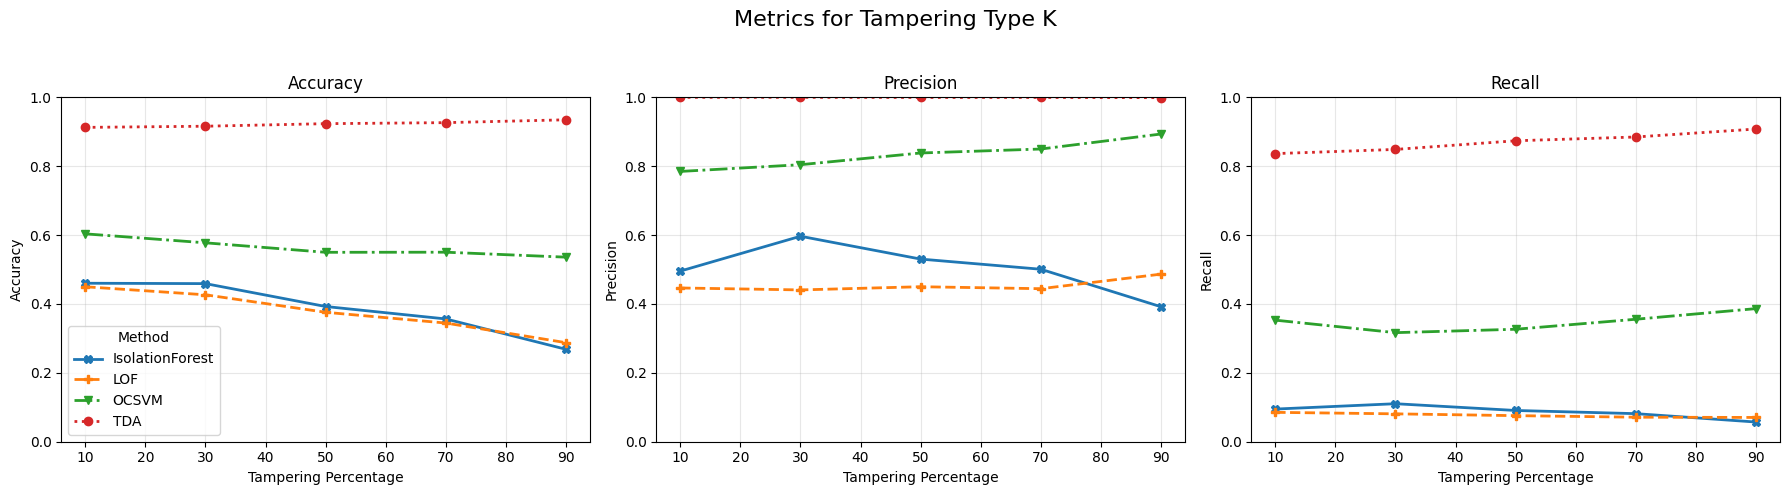

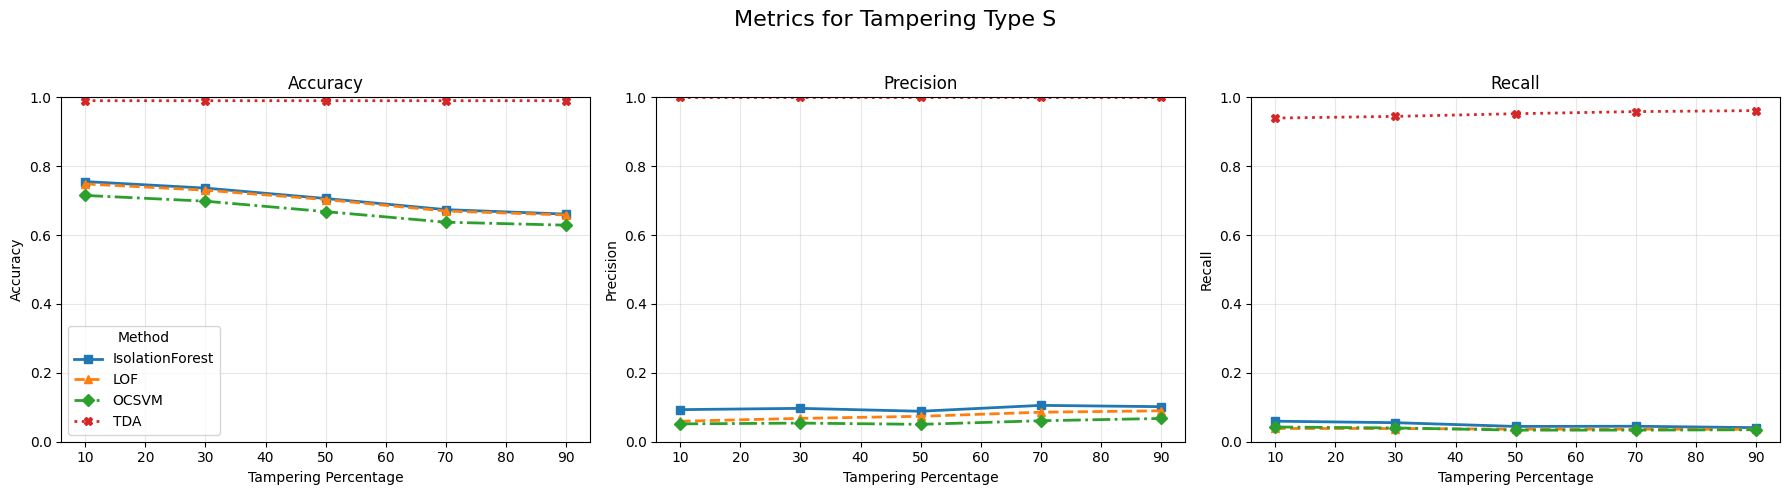

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle

# Prepare the DataFrame
metrics_df = pd.DataFrame(results_metrics).dropna(
    subset=['accuracy', 'precision', 'recall']
)

# Compute mean metrics
summary = (
    metrics_df
    .groupby(['tampering_type', 'tampering_percentage', 'method'], as_index=False)
    [['accuracy', 'precision', 'recall']]
    .mean()
)

tampering_types = ["N", "K", "S"]
metric_names = ['accuracy', 'precision', 'recall']

# Marker and line-style cycles (color-blind friendly)
markers = cycle(['o', 's', '^', 'D', 'X', 'P', 'v'])
linestyles = cycle(['-', '--', '-.', ':'])

# Loop over each tampering type
for t_type in tampering_types:
    subset_type = summary[summary['tampering_type'] == t_type]
    methods = subset_type['method'].unique()

    # Assign a unique (marker, linestyle) per method
    style_map = {
        method: (next(markers), next(linestyles))
        for method in methods
    }

    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)
    fig.suptitle(f'Metrics for Tampering Type {t_type}', fontsize=16)

    for idx, metric in enumerate(metric_names):
        ax = axes[idx]

        for method in methods:
            subset_method = subset_type[subset_type['method'] == method]
            marker, linestyle = style_map[method]

            ax.plot(
                subset_method['tampering_percentage'],
                subset_method[metric],
                marker=marker,
                linestyle=linestyle,
                linewidth=2,
                markersize=6,
                label=method
            )

        ax.set_title(metric.capitalize())
        ax.set_xlabel('Tampering Percentage')
        ax.set_ylabel(metric.capitalize())
        ax.set_ylim(0, 1)
        ax.grid(True, alpha=0.3)

    axes[0].legend(title='Method', frameon=True)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
